In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from skopt.space import Integer, Real, Categorical
from skopt import BayesSearchCV
from scipy.stats import uniform, loguniform

In [2]:
df = pd.read_csv('data/engineered_cmv&unpop_data')

In [3]:
df.drop(columns = ['Unnamed: 0'], inplace = True)

***Exploratory Data Analysis***

In [4]:
non_numerics = df.select_dtypes(exclude = np.number).columns.tolist()

In [5]:
excluded_ints = ['num_comments', 'post_score', 'training_set', 'post_subreddit']

In [6]:
ordered_sums = df.select_dtypes(include = np.dtype('int64')).drop(columns = excluded_ints).sum(numeric_only = True).sort_values(ascending = False).index

In [7]:
sentiments = ['neg_sentiment', 'pos_sentiment', 'neu_sentiment', 'comp_sentiment']

In [8]:
drops = excluded_ints.copy()
drops.extend(sentiments)

In [9]:
reindexer = []
reindexer.extend(non_numerics)
reindexer.extend(sentiments)
reindexer.extend(excluded_ints)
reindexer.extend(ordered_sums)

In [10]:
df = df.reindex(reindexer, axis=1)

- Additional cleaning after engineering.

In [11]:
df.isna().sum().sort_values(ascending = False).head()

post_text          6
post_title         4
author_username    0
leader             0
soon               0
dtype: int64

In [12]:
df.dropna(inplace = True)

- Check for artifacts with oddly high means.

In [13]:
means = df.mean(axis=0)

In [14]:
odd_ones = {key: val for key, val in means.to_dict().items() if val > 1}

- Nothing out of the ordinary here.

In [15]:
odd_ones

{'num_comments': 44.3982999914141,
 'post_score': 27.270541770412983,
 'people': 1.501588391860565,
 'like': 1.0221516270284194}

- Drop additional stopwords that were not covered by CountVectorizer.

In [16]:
mentions = df[df.columns.tolist()].sum()

In [17]:
list(mentions.keys())[10:35]

['training_set',
 'post_subreddit',
 'people',
 'like',
 'just',
 'don',
 'wa',
 'think',
 'ha',
 'http',
 'thing',
 'make',
 'time',
 'want',
 'way',
 'feel',
 'woman',
 'say',
 'know',
 'life',
 'view',
 'good',
 'change',
 'cmv',
 'really']

In [18]:
df.drop(columns = ['http', 'cmv', 've', 'ha', 'wa'], inplace = True) 

- Most frequently used words, least frequently used words.

In [19]:
mentions = df[df.columns.tolist()].sum()

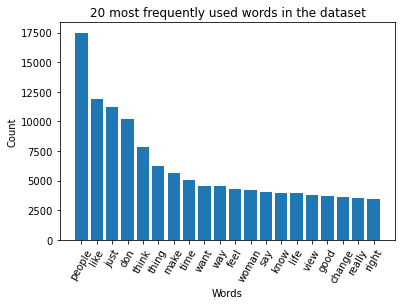

In [34]:
keys = list(mentions.to_dict().keys())
values = list(mentions.to_dict().values())

plt.bar(keys[12:32], values[12:32])
plt.xticks(rotation = 60)
plt.title("20 most frequently used words in the dataset")
plt.ylabel("Count")
plt.xlabel("Words")
plt.savefig('images/frequent_words_all.png', bbox_inches = 'tight', pad_inches = .3)

- Many posts appear to talk about (perhaps unsurprisingly) opinions, given the frequency of people, like, don't, say, feel, know, and think.

In [21]:
y_vars = excluded_ints.copy()

In [22]:
y_vars.remove('training_set')

In [23]:
y_vars.remove('post_subreddit')

In [24]:
x_vars = sentiments

- Outlier and distributions check.

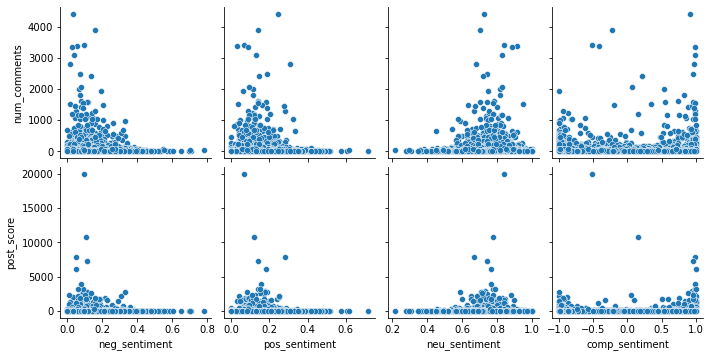

In [25]:
sns.pairplot(df, x_vars = x_vars, y_vars = y_vars)
plt.show()

- No need to remove these outliers, as post_score and num_comments both just indicate additional text data that will not be used in this analysis.
- Posts in these subreddits that receive upvotes or comments appear to be clustered around low negative and positive sentiments and high neutral sentiment.

In [26]:
df[df['post_subreddit'] == 1][x_vars].describe()

,neg_sentiment,pos_sentiment,neu_sentiment,comp_sentiment
count,5088.000000,5088.000000,5088.000000,5088.000000
mean,0.106155,0.131158,0.762689,0.231404
std,0.066121,0.055680,0.074437,0.836859
min,0.000000,0.000000,0.350000,-0.999900
25%,0.059000,0.092000,0.717000,-0.829775
50%,0.093000,0.129000,0.764000,0.758250
75%,0.142000,0.166000,0.812000,0.975125
max,0.650000,0.574000,1.000000,0.999900


In [27]:
df[df['post_subreddit'] == 0][x_vars].describe()

,neg_sentiment,pos_sentiment,neu_sentiment,comp_sentiment
count,6559.000000,6559.000000,6559.000000,6559.000000
mean,0.127399,0.134973,0.737632,0.030647
std,0.087308,0.079651,0.096616,0.761762
min,0.000000,0.000000,0.217000,-0.999700
25%,0.066000,0.081000,0.678000,-0.796550
50%,0.114000,0.126000,0.741000,0.077200
75%,0.175000,0.180500,0.801000,0.829850
max,0.783000,0.718000,1.000000,0.999800


In [45]:
#credit to: https://datavizpyr.com/overlapping-histograms-with-matplotlib-in-python/
def sentiment_grams(sentiment_label, sentiment_proper):
    plt.hist(df[df['post_subreddit'] == 0][sentiment_label], bins=100, alpha=0.5, label="Unpopular Opinion")
    plt.hist(df[df['post_subreddit'] == 1][sentiment_label], bins=100, alpha=0.5, label="Change my View")

    plt.xlabel(f"Post {sentiment_proper.lower()} sentiment score", size=14)
    plt.ylabel("Count", size=14)
    plt.title(f"{sentiment_proper} sentiment of posts in r/unpopularopinion and r/changemyview")
    plt.legend(loc='upper right')

    plt.savefig(f'images/{sentiment_label}_comparison.png', bbox_inches = 'tight', pad_inches = .3)
    plt.show()

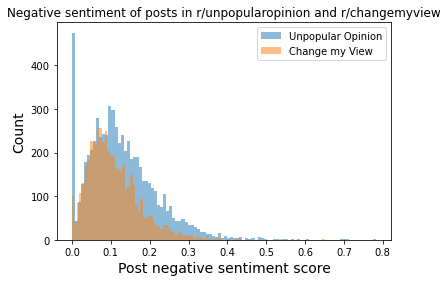

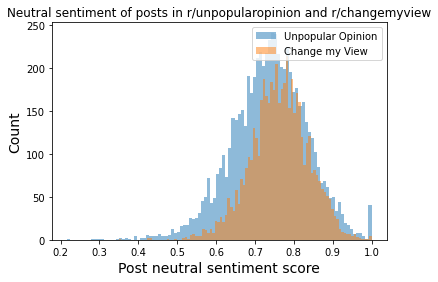

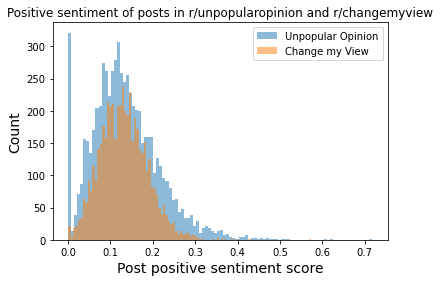

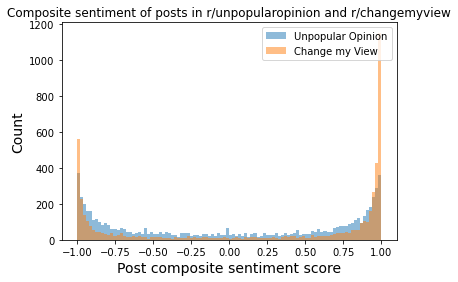

In [46]:
sentiment_grams('neg_sentiment', 'Negative')
sentiment_grams('neu_sentiment', 'Neutral')
sentiment_grams('pos_sentiment', 'Positive')
sentiment_grams('comp_sentiment', 'Composite')

- Unpopular opinion is slightly more negative in terms of language on average, but shows a higher spread across all sentiments (std).

- Create a ratio of all word counts between the two subreddits.

In [28]:
dissimilarities = df[df['post_subreddit'] == 1].drop(columns = drops).sum(numeric_only = True) / df[df['post_subreddit'] == 0].drop(columns = drops).sum(numeric_only = True)

In [29]:
dissimilarities.sort_values(ascending = True, inplace = True)

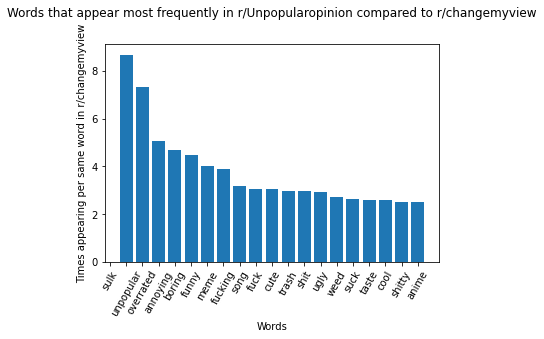

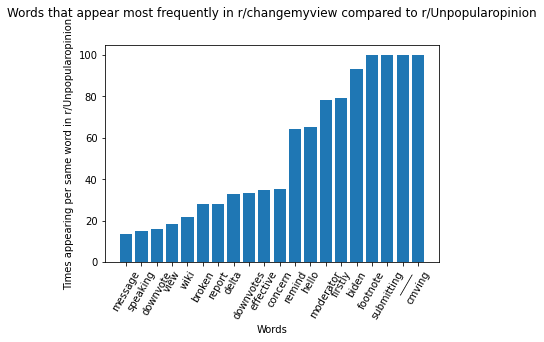

In [35]:
keys = list((1/dissimilarities).to_dict().keys())
values = list((1/dissimilarities).to_dict().values())

plt.bar(keys[:20], values[:20])
plt.xticks(rotation = 60)
plt.title("Words that appear most frequently in r/Unpopularopinion compared to r/changemyview", y= 1.1)
plt.ylabel("Times appearing per same word in r/changemyview")
plt.xlabel("Words")
plt.savefig('images/word_ratio_unpop.png', bbox_inches = 'tight', pad_inches = .3)
plt.show()

keys = list(dissimilarities.to_dict().keys())
values = list(dissimilarities.to_dict().values())

plt.bar(keys[len(dissimilarities) - 20:], [val if val <= 100 else 100 for val in values[len(dissimilarities) - 20:]])
plt.xticks(rotation = 60)
plt.title("Words that appear most frequently in r/changemyview compared to r/Unpopularopinion", y= 1.1)
plt.ylabel("Times appearing per same word in r/Unpopularopinion")
plt.xlabel("Words")
plt.savefig('images/word_ratio_cmv.png', bbox_inches = 'tight', pad_inches = .3)

- These charts show interesting differences between the two subreddits:
   - Negatively opinionated words such as 'overrated', 'annoying', 'boring', 'trash', 'shit, 'suck, and 'shitty' all appear at least three times more often in Unpopular opinion that in change my view. 
   - 'Song', 'meme', and 'anime' appear more frequently in Unpopular opinion than in change my view. Taken with the above point, it is likely that posts in Unpopular opinion are frequently about the quality of popular works of media.
   - Reddit specific language such as 'wiki', 'report', 'downvotes', 'submitting, and 'moderator' appear more frequently in change my view.
   - Hello appears much more frequently in change my view, similar to a formal email or other message.
   - Similarly, polite language such as 'concern', 'remind', and 'firstly' appear more over 20 times more frequently in change my view than in Unpopular opinion.
   - Biden appears much more frequently in change my view than in unpopular opinion, though surprisingly 'Trump' does not appear on this list. This data is scraped over a long enough period that I would have expected it.

In [31]:
dissimilarities['trump'], dissimilarities['politics']

(2.956810631229236, 2.646017699115044)

- Trump does appear more often in change my view than in unpopular opinion. Politics does as well, and the three together seem to indicate that political opinions are voice more often in change my view than in unpopular opinion as a whole. I am curious why Biden appears 90 times more often in cmv and Trump only appears 3 times more often.

In [32]:
df['trump'].sum(), df['biden'].sum()

(1191, 188)

- It appears that Biden's appearance so often in cmv compared to unpop may be due to low sample size - one tenth of the appearances that Trump makes.

- Save edited csv.

In [33]:
df.to_csv('data/explored_cmv&unpop_data')

- On to part 5 ->